In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn import set_config 
'''set_config is a utility function in scikit-learn that allows you to adjust global settings for how the library behaves. It's commonly used to
change how scikit-learn objects are displayed, control verbosity, adjust parallel processing, or manage warnings, making it easier to work with
scikit-learn, especially in interactive environments.'''

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline , FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer


import mlflow

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score , 
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay


**Load the Data**

In [2]:

df = pd.read_csv("mlflow/data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Checking missing values in data 
(
    df.
    isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 ***Age , Cabin and Embarked have missing values***

In [4]:
# info about the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Data Cleaning

In [5]:
column_to_drop = ['passengerid','name','ticket','cabin']

In [6]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=column_to_drop)
        .assign(
            family=lambda df_: df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp', 'parch'])
    )

In [7]:
final_df = clean_data(df)

In [8]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [9]:
#shape of the clean data 
final_df.shape
print(f"the cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns")

the cleaned data has 891 rows and 7 columns


#### EDA


In [10]:
final_df['survived'].value_counts().to_frame()

,count
survived,
0,549
1,342


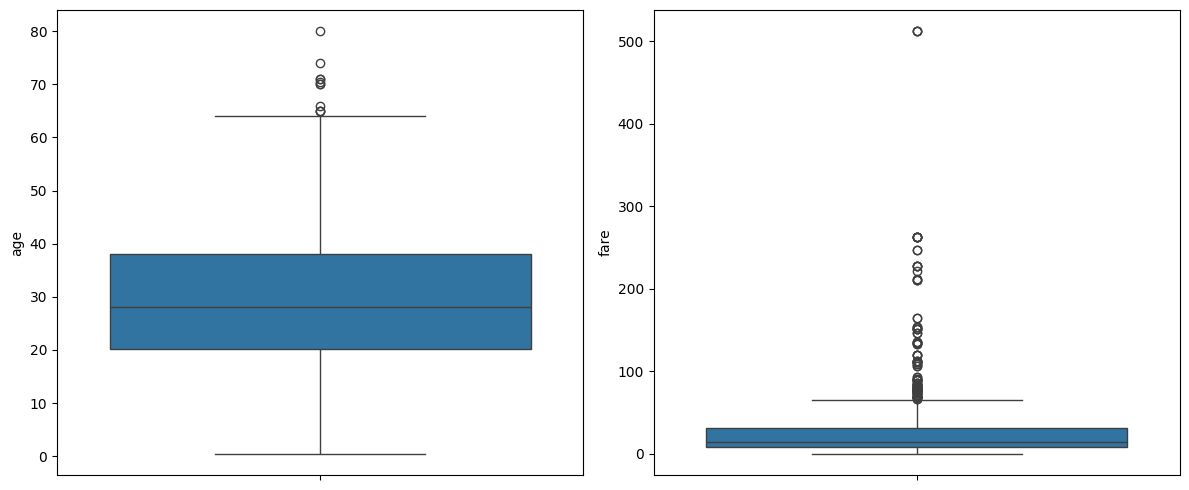

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

sns.boxplot(data=final_df, y='age', ax=ax1)
sns.boxplot(data=final_df, y='fare', ax=ax2)

plt.tight_layout()
plt.show()

#### Insight 
***Outlier in age and fare column needs to be handles***

In [12]:
# let's plot the distribution of categorical column

def plot_distribution(data, column_name):
    sns.countplot(data = data , x = column_name)

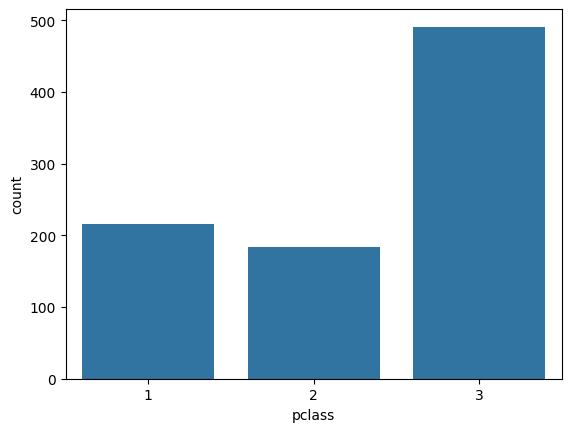

In [13]:
#distribution of pclass
plot_distribution(final_df, 'pclass')

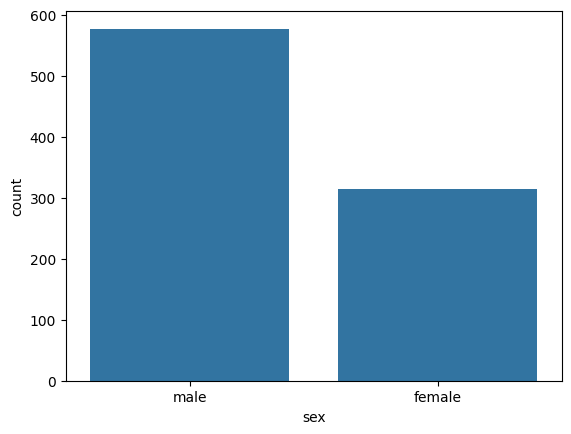

In [14]:
#distribution for sex 
plot_distribution(final_df , 'sex')

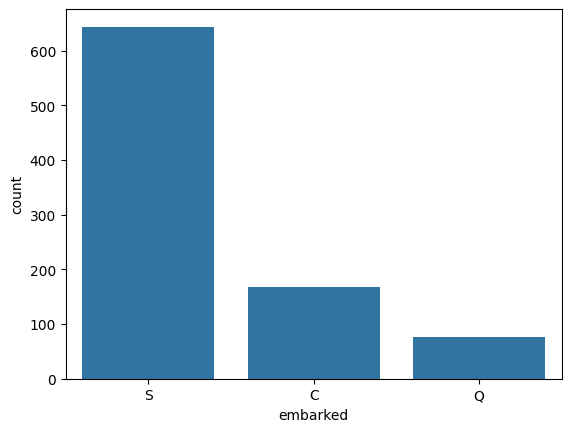

In [15]:
# distribution for embarked
plot_distribution(final_df, 'embarked')

In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   fare      891 non-null    float64
 5   embarked  889 non-null    object 
 6   family    891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


<Axes: xlabel='survived', ylabel='count'>

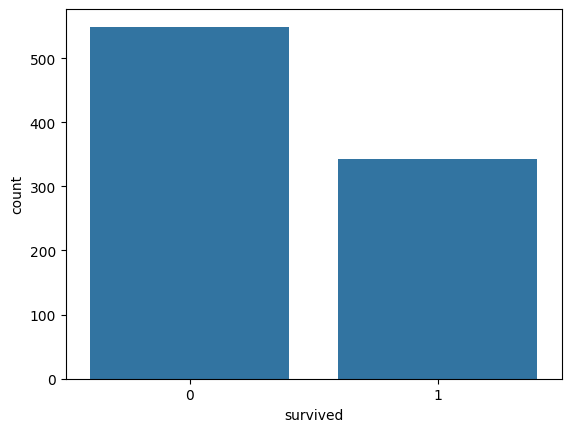

In [17]:
sns.countplot(data = final_df , x = 'survived')

#### Insight 
***Distribution of target variable is imbalanced***

#### <b>feature engineering</b>

In [18]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [19]:
# Make x and y 
X = final_df.drop(columns = ['survived'])
y = final_df['survived']

In [20]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [21]:
# Do train test split 
X_train , X_test , y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state = 42)
print("the shape of the training data is" , X_train.shape)
print("the shape of the test data is" , X_test.shape)

the shape of the training data is (712, 6)
the shape of the test data is (179, 6)


#### Pipeline for individual columns

In [22]:

# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())
])


age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer()), ('scale', StandardScaler())])

In [23]:
#Fare pipeline 

fare_pipe = Pipeline(steps = [
    ('Outliers',Winsorizer(capping_method='iqr',fold = 1.5)),
    ('scale',StandardScaler())

])

fare_pipe

Pipeline(steps=[('Outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [24]:
#embarked pipeline
embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy = 'most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method = 'count')),
    ('scale',MinMaxScaler())
])


embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

### Column Transoformer

In [25]:
set_config(transform_output='pandas')

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers', Winsorizer()),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('Outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [27]:
# fit and transform the raining data 
preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [28]:
preprocessor.get_params()

{'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer()), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('Outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer()), ('scale', StandardScaler())]),
 'fare': Pipeline(st

### Model Pipeline

In [29]:
# build the model pipeline 
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
model_param={'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.7,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [51]:
model_pipe = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier(**model_param))
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('Outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=40, max_samples=0.7,
                                        n_estimators=200))])

In [52]:
model_pipe.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('Outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=40, max_samples=0.7,
                                        n_estimators=200))])

In [53]:
# evaluate the model on test data 
y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred).item()
recall = recall_score(y_test,y_pred).item()
f1 = f1_score(y_test,y_pred).item()

In [54]:
# metrics dict

metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

metrics

{'accuracy': 0.8212290502793296,
 'precision': 0.7916666666666666,
 'recall': 0.7702702702702703,
 'f1_score': 0.7808219178082192}

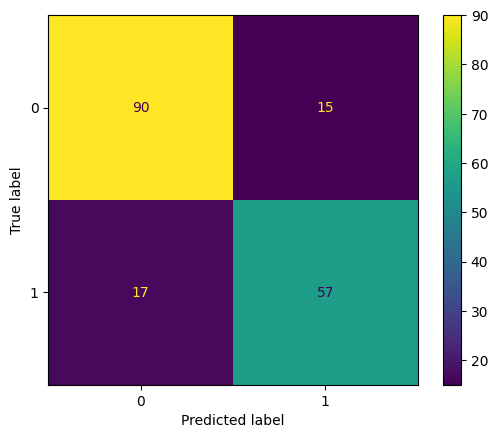

In [55]:

# plot confusion matrix

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

## Mlflow Tracking code


In [56]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(n_jobs=-1, remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers', Winsorizer()),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('Outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                                    ['fare']),
                                   ('embarked',
                                    Pipeline(s

In [57]:
X_test.join(y_test)

,pclass,sex,age,fare,embarked,family,survived
709,3,male,NaN,15.2458,C,2,1
439,2,male,31.0,10.5000,S,0,0
840,3,male,20.0,7.9250,S,0,0
720,2,female,6.0,33.0000,S,1,1
39,3,female,14.0,11.2417,C,1,1
...,...,...,...,...,...,...,...
433,3,male,17.0,7.1250,S,0,0
773,3,male,NaN,7.2250,C,0,0
25,3,female,38.0,31.3875,S,6,1
84,2,female,17.0,10.5000,S,0,1


In [58]:
mlflow.is_tracking_uri_set()

True

In [60]:
# set the uri for server
mlflow.set_tracking_uri("http://127.0.0.1:8080")

#setting the experiment name 
mlflow.set_experiment("mlflow-experiement-1")

with mlflow.start_run(run_name = "fourth run") as run:

    #log model parameter
    mlflow.log_params(model_pipe.get_params())

    
    # log the data signature
    signature = mlflow.models.infer_signature(model_input=X_train,model_output=model_pipe.predict(X_train))

    # log model metrics
    mlflow.log_metrics(metrics)

    #Tracking our model 
    mlflow.sklearn.log_model(sk_model=model_pipe,artifact_path="models",signature=signature)

    #tracking our confusion matirx
    mlflow.log_figure(figure = cm.figure_ , artifact_file="confusion_matrix.png")

    #get the model uri
    model_uri = mlflow.get_artifact_uri("model.pkl")


c:\Users\asus\Anaconda3\envs\mlflow-venv\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\asus\Anaconda3\envs\mlflow-venv\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. Thi